Wagner-Whitin Algorithm For Production Planning

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
# forecasts
data = pd.read_csv('forecast_500_day.csv', sep=";")
data

,period,forecast
0,1,135
1,2,108
2,3,120
3,4,145
4,5,137
5,6,80
6,7,119
7,8,97
8,9,98
9,10,108


In [139]:
#costs
cost_data = pd.read_csv('costs.csv', sep=";")
cost_data

,type,cost
0,setup,500
1,holding,1
2,production,5


In [140]:
# Setup Cost Per Production Run
setup_cost = cost_data.loc[0, 'cost']

# Holding Cost Per Unit
holding_cost = cost_data.loc[1, 'cost']

# Production Cost Per Unit
production_cost = cost_data.loc[2, 'cost']

In [141]:
# Create columns
data_calc = data.copy()

for i in data_calc['period'].unique():
    data_calc['Order {}'.format(i)] = 0

# Order 1
order = 1
for index, row in data_calc.iterrows():
    current_month = data_calc.loc[index,'period']
    cost = 0
    # 1 set up
    cost += setup_cost
    if current_month > 1:
        for t in range(1, current_month+1):
            cost += (t-1) * data_calc.loc[t-1,'forecast'] * holding_cost
    data_calc.loc[index,'Order {}'.format(order)] = cost

# Order 2
for order in range(2, 31):
    for index, row in data_calc.iterrows():
        current_month = data_calc.loc[index,'period']
        if current_month >= order:
            cost = 0

            # Best option best Period 1
            values = list(data_calc.loc[order-2,['Order {}'.format(i) for i in range(1, order+1)]].values)
            best = min([i for i in values if i >0])

            # Add
            cost += best + setup_cost
            for t in range(order, current_month+1):
                cost += (t-order) * data_calc.loc[t-1,'forecast'] * holding_cost
            data_calc.loc[index,'Order {}'.format(order)] = cost

data_calc = data_calc.set_index('period').drop(['forecast'], axis = 1).T
data_calc

period,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Order 1,500,608,848,1283,1831,2231,2945,3624,4408,5380,...,21843,24216,26790,28745,32225,34000,36626,39218,42886,46627
Order 2,0,1000,1120,1410,1821,2141,2736,3318,4004,4868,...,20202,22462,24919,26789,30124,31828,34353,36849,40386,43998
Order 3,0,0,1108,1253,1527,1767,2243,2728,3316,4072,...,18277,20424,22764,24549,27739,29372,31796,34196,37602,41085
Order 4,0,0,0,1348,1485,1645,2002,2390,2880,3528,...,16604,18638,20861,22561,25606,27168,29491,31795,35070,38424
Order 5,0,0,0,0,1753,1833,2071,2362,2754,3294,...,15241,17162,19268,20883,23783,25274,27496,29704,32848,36073
Order 6,0,0,0,0,0,1985,2104,2298,2592,3024,...,13842,15650,17639,19169,21924,23344,25465,27577,30590,33686
Order 7,0,0,0,0,0,0,2145,2242,2438,2762,...,12451,14146,16018,17463,20073,21422,23442,25458,28340,31307
Order 8,0,0,0,0,0,0,0,2502,2600,2816,...,11376,12958,14713,16073,18538,19816,21735,23655,26406,29244
Order 9,0,0,0,0,0,0,0,0,2742,2850,...,10281,11750,13388,14663,16983,18190,20008,21832,24452,27161
Order 10,0,0,0,0,0,0,0,0,0,2938,...,9240,10596,12117,13307,15482,16618,18335,20063,22552,25132


In [142]:
costs, initials, nexts, quantities = [], [], [], []
i = 30
while i>1:
    # Order with the minimum cost
    initial_step = i
    next_step = data_calc[data_calc[i]>0][i].idxmin()
    cost = data_calc[data_calc[i]>0][i].min()
    # Next Step
    next_id = int(next_step.replace('Order ',''))
    i = next_id - 1
    # Quantity
    quantity = data[data['period'].isin(range(next_id, initial_step+1))]['forecast'].sum()

    costs.append(cost)
    initials.append(initial_step)
    nexts.append(next_id)
    quantities.append(quantity)

df_results = pd.DataFrame({'backward':range(1, len(initials)+1),
                           'initial':initials,
                           'nexts':nexts,
                           'cost':costs,
                           'quantity':quantities}).set_index('backward')
df_results

,initial,nexts,cost,quantity
backward,,,,
1,30,28,8071,356
2,27,25,7182,317
3,24,22,6409,315
4,21,19,5622,238
5,18,16,4941,333
6,15,13,4119,326
7,12,10,3299,340
8,9,7,2438,314
9,6,4,1645,362


In [143]:
# Final Results
results_final = data.copy()

# Production
month_prod = df_results['nexts'].values
prod_dict = dict(zip(month_prod, df_results.quantity.values))

# Values
results_final['production'] = results_final['period'].apply(lambda t: prod_dict[t] if t in month_prod else 0)

# Inventory On Hand
results_final['IOH'] = (results_final['production'] - results_final['forecast']).cumsum()

# Holding Cost
results_final['Holding Cost'] = (results_final['IOH'] * holding_cost)

# Set Up Cost
results_final['Set-Up Costs'] = results_final['production'].apply(lambda t: setup_cost if t > 0 else 0)

# Production Cost
results_final['Production Cost'] = (results_final['production'] * production_cost)

# Total Cost
results_final['Total Cost'] = results_final[['Holding Cost', 'Set-Up Costs', 'Production Cost']].sum(axis = 1)

Total = results_final['Total Cost'].sum()
print("Total Cost: {:,}$".format(Total))
results_final

Total Cost: 24,391$


,period,forecast,production,IOH,Holding Cost,Set-Up Costs,Production Cost,Total Cost
0,1,135,363,228,228,500,1815,2543
1,2,108,0,120,120,0,0,120
2,3,120,0,0,0,0,0,0
3,4,145,362,217,217,500,1810,2527
4,5,137,0,80,80,0,0,80
5,6,80,0,0,0,0,0,0
6,7,119,314,195,195,500,1570,2265
7,8,97,0,98,98,0,0,98
8,9,98,0,0,0,0,0,0
9,10,108,340,232,232,500,1700,2432


Text(0, 0.5, 'Units')

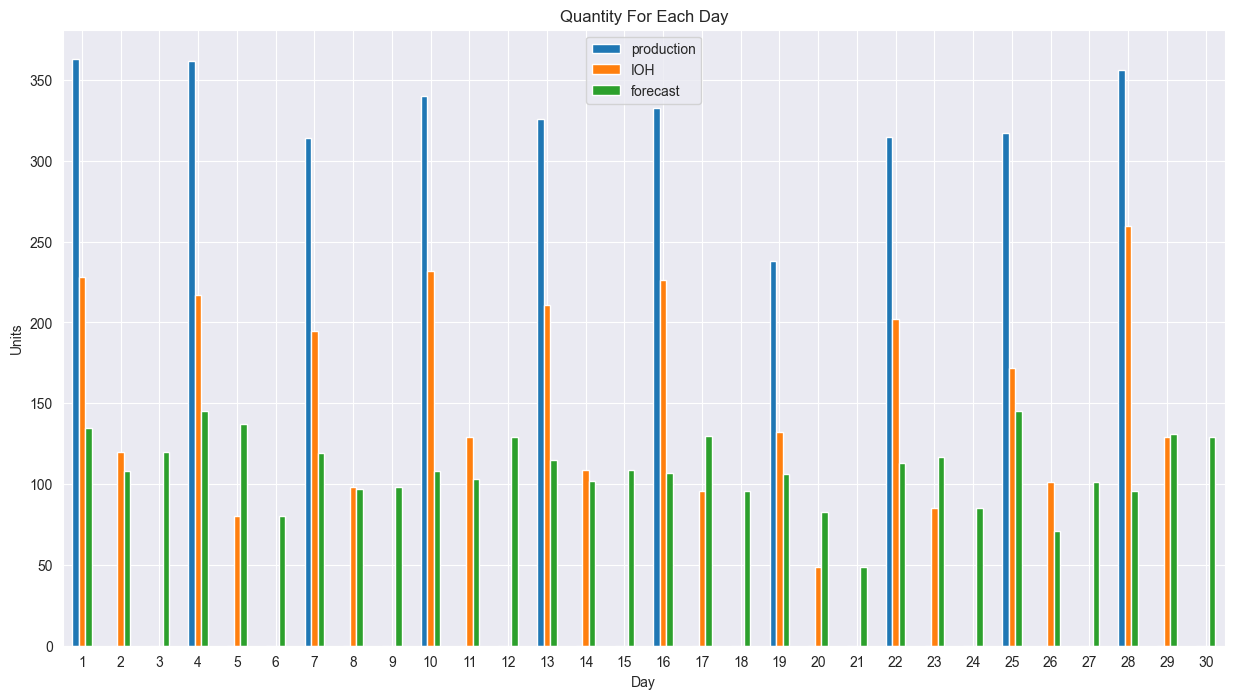

In [144]:
results_final.plot.bar(x = 'period', y = ['production', 'IOH', 'forecast'], rot = 360, figsize=(15, 8))
plt.title("Quantity For Each Day")
plt.xlabel("Day")
plt.ylabel("Units")

In [145]:
print("Total Cost: {:,}$".format(round(Total)))

Total Cost: 24,391$
